In [ ]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.signal as signal
import peakutils
import wfdb
from wfdb import processing
import ast
import neurokit2 as nk

from sklearn.preprocessing import OneHotEncoder

Loading the data

In [3]:
#Load raw_signals in array format
raw_signals = np.load('../data/created_data_files/ptb_raw_signals.npz')
raw_signals = raw_signals['arr_0']

In [4]:
raw_signals[0:1]

array([[[-0.119, -0.055,  0.064, ..., -0.026, -0.039, -0.079],
        [-0.116, -0.051,  0.065, ..., -0.031, -0.034, -0.074],
        [-0.12 , -0.044,  0.076, ..., -0.028, -0.029, -0.069],
        ...,
        [ 0.069,  0.   , -0.069, ...,  0.024, -0.041, -0.058],
        [ 0.086,  0.004, -0.081, ...,  0.242, -0.046, -0.098],
        [ 0.022, -0.031, -0.054, ...,  0.143, -0.035, -0.12 ]]],
      dtype=float16)

In [5]:
#Load raw_signals that were converted to dataframe
signals_df = pd.read_csv('../data/created_data_files/ptb_signals_df.csv.gz', compression='gzip')

In [6]:
signals_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.119,-0.055,0.064,0.086,-0.091,0.004,-0.069,-0.031,0.000,-0.026,-0.039,-0.079
1,-0.116,-0.051,0.065,0.083,-0.090,0.006,-0.064,-0.036,-0.003,-0.031,-0.034,-0.074
2,-0.120,-0.044,0.076,0.082,-0.098,0.016,-0.058,-0.034,-0.010,-0.028,-0.029,-0.069
3,-0.117,-0.038,0.080,0.077,-0.098,0.021,-0.050,-0.030,-0.015,-0.023,-0.022,-0.064
4,-0.103,-0.031,0.072,0.066,-0.087,0.021,-0.045,-0.027,-0.020,-0.019,-0.018,-0.058


## Section 2: Feature Engineering

### Part 2.1: Creating features

#### Calculating Skew and Kurtosis

Let's calculate the skewness of one of the channels of an ecg. Apply a scipy skew function to a rolling window of the whole 10 seconds

In [30]:
#Define the scipy function and window size to be used
skew_func = sp.stats.skew
window = 1000

In [31]:
#Applying the skew function to ecg 0, whole 10 seconds, first lead, which is raw_signals[0][0:999][0]
#or signals_df[0:1000]
skew_first_ecg = pd.DataFrame.rolling(signals_df[0:1000],window).skew
print(skew_first_ecg().iloc[999])

0     2.350041
1     1.826513
2    -0.833393
3    -2.266357
4     2.084855
5     0.757849
6    -4.019669
7    -3.866994
8    -0.825758
9     2.247386
10    3.170848
11    1.842737
Name: 999, dtype: float64


Define a new function to apply functions like mean, skew, and other function names and return the results in a dataframe for that dataframe

In [33]:
def func_on_ecg(dataframe, function_name='skew'):
    """
    Input: A dataframe with 21837000 rows and 12 columns, with each row being a time step and each column being a lead
    of the ecg reading
    Output: A dataframe with 21837 rows and 12 columns, with each row being one ecg and each column being a lead
    of the ecg reading. Each value will be the applied function's values, e.g. 'mean' will retrieve the mean
    """
    output_df = pd.DataFrame(data=None)
    
    # For each of the 12-leads, do...
    for i in range(12):
    
        # Convert the dataframe into a (1000,21837) dataframe, with each column being 1 ecg for the 1000 time steps
        changed_df = pd.DataFrame(signals_df.iloc[:,i].values.reshape(21837,1000)).T
        
        #Apply the function per variable
        ecg_values = getattr(changed_df, function_name)()
        
        #Turn the above output_array into a dataframe for concatenation
        df_for_appending = pd.DataFrame(ecg_values)
        
        #Concatenate df_for_appending to the output_df
        output_df = pd.concat([output_df, df_for_appending], axis=1)
    
    #Rename columns with lead number
    output_df.columns = [0,1,2,3,4,5,6,7,8,9,10,11]
    
    return output_df
        

In [34]:
kurtosis_df = func_on_ecg(signals_df, 'kurtosis')

In [35]:
kurtosis_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,10.157935,4.328929,2.532020,8.238752,9.594229,0.375750,18.071303,19.795272,11.237391,10.617874,12.214675,5.147682
1,4.769903,4.813885,0.640792,6.180401,0.046094,2.934988,23.824283,22.847099,13.001364,21.108446,27.573093,24.230976
2,17.754184,2.299330,-0.975719,11.798778,5.049829,-0.941430,18.931060,27.281625,9.979333,22.148209,19.675563,13.402693
3,3.917500,1.206606,1.018650,1.562617,1.230360,1.081754,1.691806,6.935032,5.224970,8.577816,8.096733,6.798000
4,6.943649,6.158472,5.219086,6.943936,5.080905,5.660265,17.707260,16.120591,4.222095,17.399847,19.131684,20.223961
...,...,...,...,...,...,...,...,...,...,...,...,...
21832,13.556156,35.354265,36.416549,13.276493,11.315225,57.458260,13.184845,7.103624,11.850347,21.100089,20.332755,19.490903
21833,18.812110,3.704490,10.714302,11.546126,22.827868,1.087854,18.251425,15.039019,11.992038,18.362139,24.050384,24.539400
21834,25.735951,23.163058,0.892235,25.172050,21.693675,17.527640,18.519264,18.454542,16.166233,29.049975,37.054482,24.597620
21835,20.467263,3.253892,6.510273,9.515733,15.900864,3.194228,21.073890,17.731488,15.163138,12.425747,11.962876,13.371843


In [36]:
skew_df = func_on_ecg(signals_df, 'skew')

In [37]:
skew_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,2.350041,1.826513,-0.833393,-2.266357,2.084855,0.757849,-4.019669,-3.866994,-0.825758,2.247386,3.170848,1.842737
1,1.963716,1.396514,0.391310,-1.899722,0.234151,0.916992,-4.363501,-4.094463,-2.386420,3.491435,4.566282,4.230554
2,3.699663,0.880926,-0.138469,-2.699717,1.622725,-0.048932,-3.805731,-4.531192,0.985947,3.950945,3.751033,2.918737
3,0.022340,0.346914,0.000119,-0.634379,0.084238,0.160513,-0.700770,-1.599300,-0.986866,1.728574,2.010507,2.010747
4,1.976989,1.385671,0.825154,-1.802800,-0.691333,1.101426,-3.902199,-3.567868,0.831926,3.603013,3.850054,4.036696
...,...,...,...,...,...,...,...,...,...,...,...,...
21832,3.397424,3.348835,1.919294,-3.239857,1.291461,3.560236,-3.181269,-1.216625,0.281938,2.373917,3.593706,3.954109
21833,4.031430,1.704853,-2.723361,-3.011203,4.601728,0.446547,-4.262518,-2.687253,-0.471007,2.066618,3.779244,4.499763
21834,4.726747,4.323884,0.464117,-4.618798,4.205937,3.524334,-4.219613,-2.951827,-1.710135,4.078507,5.843697,4.673413
21835,4.127478,1.344204,-1.217574,-2.679736,3.831924,0.142174,-4.147099,-2.495064,-1.758058,0.767449,2.205303,3.164337


Calculate the discrete wavelet transform for the signals

In [38]:
#nk.signal_timefrequency gets the frequency and time components as a wavelet. It outputs a list of arrays.
#The first array is the frequency array
#The second array is the time array
#The third array is the Short-Term Fourier Transform
time_freq_array = nk.signal_timefrequency(signals_df.iloc[1000:2000,1], sampling_rate=100, method ='cwt', show=False);


C:\Users\junho\anaconda3\lib\site-packages\neurokit2\signal\signal_timefrequency.py:479: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  spec = ax.pcolormesh(time, f, z, cmap=plt.get_cmap("magma"))


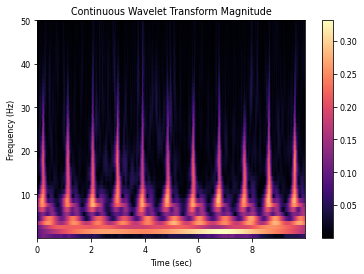

In [39]:
#Let's try using nk.signal_timefrequency to get the short-time fourier transform
time_freq_array = nk.signal_timefrequency(signals_df.iloc[0:1000,1], sampling_rate=100, method ='cwt');

#### Calculating Short-Time Fourier Transform

Let's define a function to get the short-time fourier transform for each patient in the dataframe. Sum up these values so that it works as a feature

In [40]:
def stft_on_df(dataframe):
    """
    Input: A dataframe with 21837000 rows and 12 columns, with each row being a time step and each column being a lead
    of the ecg reading
    Output: A dataframe with 21837 rows and 12 columns, with each row being one ecg and each column being a lead
    of the ecg reading. Values in this dataframe will be the sum of the short-time fourier transform, which can be
    used as a feature
    """
    output_df = pd.DataFrame(data=None)
    
    # For each of the 12-leads, do...
    for i in range(12):
    
        # Convert the dataframe into a (1000,21837) dataframe, with each column being 1 ecg for the 1000 time steps
        changed_df = pd.DataFrame(signals_df.iloc[:,i].values.reshape(21837,1000)).T
        
        #Apply the signal_timefrequency function from neurokit2 for each column. Access the 2nd value, which
        #is an array of the short-time fourier transform values
        functioned_df = changed_df.apply(lambda x : nk.signal_timefrequency(x, show = False), axis=0).iloc[2]
        
        #Initiate empty array to store the sum for the next step
        output_array = []
        
        #Sum up the short-time fourier transform values
        [output_array.append(np.sum(functioned_df[j])) for j in range(21837)]
        
        #Turn the above output_array into a dataframe for concatenation
        df_for_appending = pd.DataFrame(output_array)
        
        #Concatenate df_for_appending to the output_df
        output_df = pd.concat([output_df, df_for_appending], axis=1)
    
    #Rename columns with lead number
    output_df.columns = [0,1,2,3,4,5,6,7,8,9,10,11]
    
    return output_df
        

In [41]:
#Applying the stft_on_df function and saving the output to stft_df
stft_df = stft_on_df(signals_df)

C:\Users\junho\anaconda3\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 50000 is greater than input length  = 1000, using nperseg = 1000
  warnings.warn('nperseg = {0:d} is greater than input length '


In [42]:
#Viewing stft_df
stft_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.009498,0.006770,0.002542,0.007496,0.004322,0.002260,0.011932,0.044315,0.013111,0.008417,0.007416,0.010144
1,0.018909,0.062614,0.030804,0.033114,0.009208,0.041913,0.051427,0.195585,0.141215,0.082111,0.053348,0.035421
2,0.013442,0.022840,0.018169,0.013614,0.010116,0.017084,0.013285,0.020004,0.028149,0.020855,0.012951,0.011703
3,0.018311,0.187726,0.152366,0.064989,0.038479,0.165336,0.031618,0.158257,0.290110,0.281170,0.146551,0.080364
4,0.006882,0.042188,0.023640,0.018650,0.004734,0.031136,0.019298,0.114756,0.041414,0.054524,0.044486,0.031690
...,...,...,...,...,...,...,...,...,...,...,...,...
21832,0.044474,0.078888,0.085877,0.040202,0.045435,0.071200,0.016302,0.079413,0.153106,0.172159,0.217214,0.138935
21833,0.009403,0.006266,0.002852,0.007122,0.004553,0.002191,0.009474,0.037965,0.032538,0.036174,0.030595,0.019653
21834,0.008551,0.010388,0.000942,0.009243,0.002145,0.003508,0.017159,0.027091,0.020929,0.018306,0.012657,0.009543
21835,0.009932,0.016253,0.007203,0.011304,0.004504,0.009218,0.007968,0.080955,0.050485,0.043111,0.028126,0.015470


#### Calculate Fast Fourier Transform

In [57]:
def fft_on_df(dataframe):
    """
    Input: A dataframe with 21837000 rows and 12 columns, with each row being a time step and each column being a lead
    of the ecg reading
    Output: A dataframe with 21837 rows and 12 columns, with each row being one ecg and each column being a lead
    of the ecg reading. Values in this dataframe will be the sum of the short-time fourier transform, which can be
    used as a feature
    """
    output_df = pd.DataFrame(data=None)
    
    # For each of the 12-leads, do...
    for i in range(12):
    
        # Convert the dataframe into a (1000,21837) dataframe, with each column being 1 ecg for the 1000 time steps
        changed_df = pd.DataFrame(signals_df.iloc[:,i].values.reshape(21837,1000)).T
        
        #Apply the signal_resample function from neurokit2 for each column. Access the 2nd value, which
        #is an array of the short-time fourier transform values
        functioned_df = changed_df.apply(lambda x : nk.signal_resample(signal=x, 
                                                                       sampling_rate=100, 
                                                                       desired_sampling_rate=100,
                                                                       method='fft'), axis=0).iloc[2]
        
        #Initiate empty array to store the sum for the next step
        output_array = []
        
        #Sum up the short-time fourier transform values
        [output_array.append(np.sum(functioned_df[j])) for j in range(21837)]
        
        #Turn the above output_array into a dataframe for concatenation
        df_for_appending = pd.DataFrame(output_array)
        
        #Concatenate df_for_appending to the output_df
        output_df = pd.concat([output_df, df_for_appending], axis=1)
    
    #Rename columns with lead number
    output_df.columns = [0,1,2,3,4,5,6,7,8,9,10,11]
    
    return output_df

In [61]:
fft_df = fft_on_df(signals_df)

In [63]:
fft_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.120,-0.044,0.076,0.082,-0.098,0.016,-0.058,-0.034,-0.010,-0.028,-0.029,-0.069
1,-0.053,0.092,0.145,-0.020,-0.100,0.118,-0.082,0.043,0.069,0.107,0.013,0.022
2,-0.054,-0.057,-0.003,0.056,-0.025,-0.030,0.019,-0.048,-0.105,-0.078,-0.066,-0.054
3,-0.063,-0.153,-0.090,0.108,0.014,-0.121,0.032,-0.051,-0.059,-0.312,-0.193,-0.185
4,-0.057,-0.584,-0.527,0.320,0.235,-0.555,0.195,0.242,0.126,0.157,0.130,0.110
...,...,...,...,...,...,...,...,...,...,...,...,...
21832,-0.042,-0.019,0.022,0.031,-0.032,0.002,0.023,-0.015,0.063,-0.013,-0.053,-0.022
21833,0.008,0.047,0.039,-0.028,-0.016,0.043,0.009,0.006,0.019,0.019,0.011,0.002
21834,-0.014,-0.006,0.008,0.009,-0.011,0.001,0.084,0.075,0.022,0.009,0.030,0.047
21835,0.003,0.045,0.042,-0.024,-0.020,0.043,0.071,-0.029,0.348,-0.009,-0.014,-0.014


### Part 2.2: Handling meta_data_df one-hot encoding variables

In [43]:
ohe = pd.get_dummies(meta_data_df['diagnostic_superclass'], drop_first=True)

In [44]:
#Concatenate the dummy variables df with Y and drop the diagnostic_superclass column
meta_data_df = pd.concat([meta_data_df, ohe], axis=1).drop(['diagnostic_superclass'], axis=1)

In [45]:
#Check Y
meta_data_df.tail()

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,HYP,MI,NORM,NO_DIAG,STTC
ecg_id,,,,,,,,,,,,,,,,,,,,,
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr,0,0,0,0,1
21834,20703.0,93.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr,0,0,1,0,0
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr,0,0,0,0,1
21836,8873.0,64.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-09 18:21:49,supraventrikulÄre extrasystole(n) sinusrhythmu...,...,SVES,NaN,8,records100/21000/21836_lr,records500/21000/21836_hr,0,0,1,0,0
21837,11744.0,68.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-11 16:43:01,sinusrhythmus p-sinistrocardiale lagetyp norma...,...,NaN,NaN,9,records100/21000/21837_lr,records500/21000/21837_hr,0,0,1,0,0


### Part 2.2: Combining the features together

Linearly combine the features together by adding the values up element wise.

In [64]:
#Linearly combining the features together. Note that columns and index are the same for all the dataframes.
combined_features_df = pd.DataFrame(kurtosis_df.values + skew_df.values + stft_df.values + fft_df.values, 
                                    columns = kurtosis_df.columns, index = kurtosis_df.index)

In [65]:
combined_features_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,12.397474,6.118213,1.777169,6.061891,11.585405,1.151859,14.005566,15.938594,10.414744,12.845677,15.363940,6.931563
1,6.699528,6.365014,1.207906,4.293792,0.189453,4.011892,19.430209,18.991222,10.825160,24.788992,32.205723,28.518951
2,21.413290,3.146097,-1.099018,9.168676,6.657670,-1.003277,15.157614,22.722437,10.888429,26.042009,23.373547,16.279133
3,3.895152,1.588246,1.081135,1.101226,1.367077,1.286603,1.054654,5.442990,4.469213,10.275561,10.060791,8.704111
4,8.870520,7.002331,5.540879,5.479785,4.629307,6.237827,14.019359,12.909479,5.221435,21.214383,23.156223,24.402347
...,...,...,...,...,...,...,...,...,...,...,...,...
21832,16.956053,38.762988,38.443720,10.107838,12.620121,61.091696,10.042878,5.951412,12.348391,23.633165,24.090676,23.561946
21833,22.860942,5.462609,8.032793,8.514045,27.418150,1.579592,14.007382,12.395730,11.572569,20.483931,27.871222,29.060816
21834,30.457249,27.491329,1.365294,20.571495,25.890757,21.056483,14.400810,15.604805,14.499027,33.155788,42.940835,29.327576
21835,24.607674,4.659349,5.341902,6.823301,19.717292,3.388619,17.005759,15.288379,13.803564,13.227306,14.182306,16.537651


### Part 2.3: Saving the features and meta-data information

Save the features dataframe as a csv file for use in modelling.

In [47]:
combined_features_df.to_csv('../data/created_data_files/combined_features', index=False)

Save the meta_data_df as a csv

In [48]:
meta_data_df.to_csv('../data/created_data_files/meta_data_df', index=False)